# Co-occurrence method


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from vinecopulas.vinecopula import fit_vinecop, sample_vinecop
from prisk.analysis_functions import minimax_ordering

basin_timeseries = pd.read_csv("https://kuleuven-prisk.s3.eu-central-1.amazonaws.com/india_basins_timeseries.csv")
used_basins = pd.read_csv("https://kuleuven-prisk.s3.eu-central-1.amazonaws.com/india_used_basins.csv")
num_samples = 50000
basin_timeseries.index = pd.to_datetime(basin_timeseries["time"])
basin_timeseries = basin_timeseries.drop(columns=["time"])
basin_timeseries = basin_timeseries[used_basins["basins"].apply(lambda x: str(x)).values]
basin_timeseries

,4061013640,4061013550,4060028210,4060027100,4061045970,4061051450,4060032890,4060898640,4060029870,4060911950,...,4060908910,4060029250,4061145720,4060895930,4061097120,4061067580,4061148790,4061065530,4060911460,4060027460
time,,,,,,,,,,,,,,,,,,,,,
1979-01-01,7.593750,18.187500,725.968750,715.40625,23.578125,8.031250,0.031250,8.250000,56.265625,1936.5156,...,14.375000,107.640625,41.125000,1.203125,21.328125,3.328125,231.76562,8.718750,302.96875,42.546875
1979-01-02,7.437500,17.484375,539.078100,707.34375,23.031250,6.859375,0.031250,7.937500,54.890625,1925.0469,...,14.234375,58.250000,38.765625,1.156250,21.015625,3.390625,223.31250,8.578125,301.34375,42.250000
1979-01-03,7.265625,16.640625,392.546880,699.15625,22.468750,5.656250,0.031250,7.656250,53.453125,1912.8750,...,14.078125,31.625000,37.015625,1.109375,20.812500,3.437500,216.62500,8.421875,299.57812,41.984375
1979-01-04,7.046875,15.781250,285.921880,690.75000,22.093750,4.828125,0.031250,7.265625,52.156250,1857.7969,...,13.625000,21.578125,35.562500,1.078125,20.406250,3.453125,200.18750,8.187500,291.15625,41.750000
1979-01-05,6.781250,15.343750,208.390620,681.92190,21.937500,4.593750,0.031250,6.796875,51.109375,1773.8438,...,13.015625,16.593750,34.265625,1.078125,19.781250,3.406250,168.79688,7.968750,278.37500,41.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,6.765625,23.789062,1.859375,741.81250,22.476562,18.750000,0.031250,4.734375,57.046875,1843.2344,...,3.304688,9.804688,109.289060,3.835938,20.468750,7.835938,650.71094,6.671875,301.72656,64.179690
2015-12-28,6.484375,22.898438,1.585938,732.36720,22.031250,17.828125,0.023438,4.687500,56.179688,1833.2969,...,3.242188,9.296875,105.203125,3.773438,19.976562,7.750000,631.23440,6.562500,301.32030,63.476562
2015-12-29,6.171875,22.062500,1.390625,723.56250,21.609375,16.648438,0.023438,4.656250,55.375000,1825.8516,...,3.187500,9.531250,101.117190,3.726562,19.632812,7.703125,612.06250,6.445312,300.84375,62.843750


In [13]:
timeseries = pd.DataFrame(basin_timeseries)
threshold = 0.975
for basin in timeseries.columns:
    quantile = np.quantile(timeseries[basin], threshold)
    timeseries[basin] = timeseries[basin].apply(lambda x: int(x > quantile))
    indexes = timeseries[basin][timeseries[basin] > 0].index
# Getting the lagged indexes
lagged_indexes = []
for index in list(indexes):
    # Get the subsequent 3 dates
    next_dates = pd.date_range(start=index, periods=9, freq='D')
    lagged_indexes.extend(next_dates)
lagged_indexes = [date for date in lagged_indexes if date in timeseries.index]

timeseries.loc[lagged_indexes, basin] = 1
occurrences = timeseries

In [17]:
from prisk.analysis_functions import minimax_ordering

basin_ids = basin_timeseries.columns
dependence_matrix = np.array(occurrences.corr())

ordered_basins = minimax_ordering(dependence_matrix, basin_ids)
occurrences = occurrences[ordered_basins]

In [4]:
# Uniform random numbers
u = np.random.uniform(0, 1, (num_samples, basin_timeseries.shape[1]))
#pd.DataFrame(u, columns=basin_timeseries.columns).to_parquet("uniform_random_numbers_india.parquet.gzip", compression="gzip", index=False)

# Perfect dependence
u = np.random.uniform(0, 1, (num_samples, 1))
u = pd.DataFrame(u, columns=[basin_timeseries.columns[0]])
for col in basin_timeseries.columns[1:]:
    u[col] = u[basin_timeseries.columns[0]]
#pd.DataFrame(u).to_parquet("complete_dependent_random_numbers_india.parquet.gzip", compression="gzip", index=False)

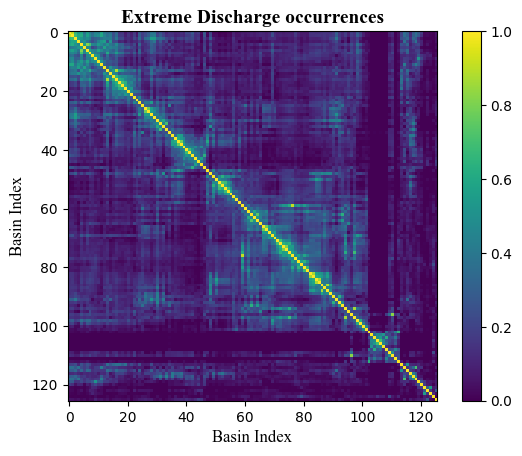

In [19]:
occurrences.columns = occurrences.columns.astype(str)

plt.imshow(occurrences.corr(), cmap='viridis', interpolation='none', vmin=0, vmax=1)
plt.colorbar()
plt.title('Extreme Discharge occurrences', fontname="times new roman", fontsize=14, fontweight='bold')
plt.xlabel('Basin Index', fontname="times new roman", fontsize=12)
plt.ylabel('Basin Index', fontname="times new roman", fontsize=12)
plt.savefig('Real Data.png', transparent=True)

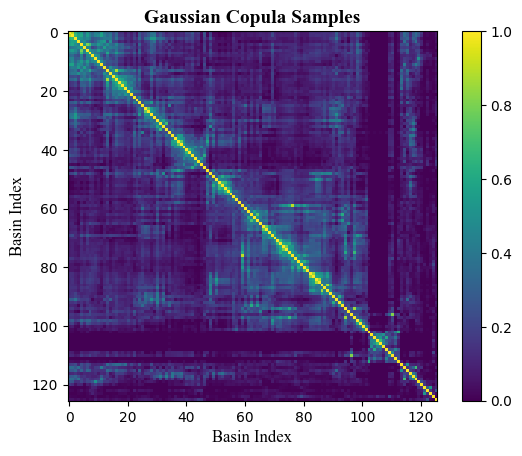

In [20]:
correlation = occurrences.corr()

means = np.zeros(correlation.shape[1])
samples = np.random.multivariate_normal(means, correlation, size=num_samples)
samples = pd.DataFrame(samples, columns=occurrences.columns)

for column_name in samples.columns:
    cdf = stats.norm.cdf(samples[column_name])
    samples[column_name] = stats.uniform.ppf(cdf)

samples = pd.read_parquet("../Data/gaussian_random_numbers_cooccurrence_india.parquet.gzip")
samples = samples[ordered_basins]
plt.imshow(samples.corr(), cmap='viridis', interpolation='none', vmin=0, vmax=1)
plt.colorbar()
plt.title('Gaussian Copula Samples', fontname="times new roman", fontsize=14, fontweight='bold')
plt.xlabel('Basin Index', fontname="times new roman", fontsize=12)
plt.ylabel('Basin Index', fontname="times new roman", fontsize=12)
plt.savefig('Gaussian Copula.png', transparent=True)

In [7]:
#samples.to_parquet("gaussian_random_numbers_cooccurrence_india.parquet.gzip", compression='gzip', index=False)

36402     18.289871
5039      18.522677
7961      18.976662
14233     19.467147
31729     19.710802
            ...    
30789    105.083672
37605    105.347840
48730    106.018095
39892    107.171834
27488    108.592754
Length: 50000, dtype: float64

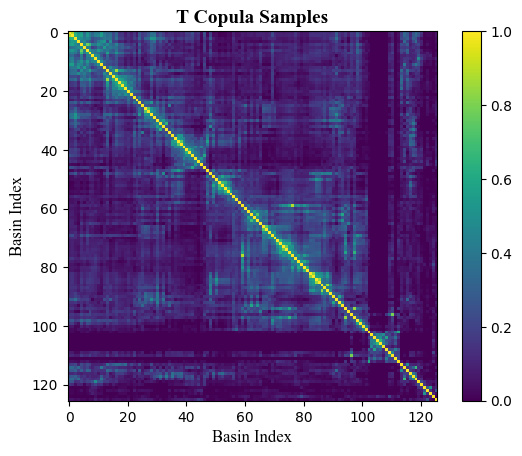

In [48]:
t_samples = {}

df = 20
corr_matrix = correlation
mu = np.zeros(len(corr_matrix))
s = stats.chi2.rvs(df=df, size=num_samples)[:, np.newaxis]
Z = np.random.multivariate_normal(mu, corr_matrix, num_samples)
X = np.sqrt(df/s)*Z
U = stats.t.cdf(X, df=df)
t_samples = pd.DataFrame(U, columns=occurrences.columns)

t_samples.to_parquet("t_random_numbers_cooccurrence_india_25.parquet.gzip", compression='gzip', index=False)

samples = pd.read_parquet("../Data/t_random_numbers_cooccurrence_india.parquet.gzip")
samples = samples[ordered_basins]
plt.imshow(samples.corr(), cmap='viridis', interpolation='none', vmin=0, vmax=1)
plt.colorbar()
plt.title('T Copula Samples', fontname="times new roman", fontsize=14, fontweight='bold')
plt.xlabel('Basin Index', fontname="times new roman", fontsize=12)
plt.ylabel('Basin Index', fontname="times new roman", fontsize=12)
plt.savefig('T Copula.png', transparent=True)

t_samples.sum(axis=1).sort_values()

In [27]:
#M, P, C = fit_vinecop(occurrences.values, copsi=list(range(1, 15)))
#vine_samples = pd.DataFrame(sample_vinecop(M, P, C, 500), columns=occurrences.columns)

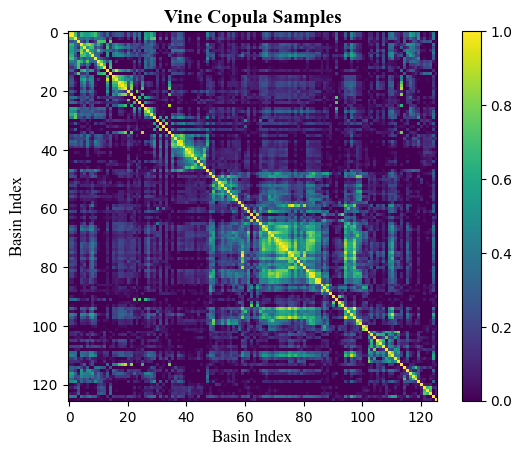

In [22]:
samples = pd.read_parquet("../Data/vine_random_numbers_cooccurrence_india.parquet.gzip")
samples = samples[ordered_basins]
plt.imshow(samples.corr(), cmap='viridis', interpolation='none', vmin=0, vmax=1)
plt.colorbar()
plt.title('Vine Copula Samples', fontname="times new roman", fontsize=14, fontweight='bold')
plt.xlabel('Basin Index', fontname="times new roman", fontsize=12)
plt.ylabel('Basin Index', fontname="times new roman", fontsize=12)
plt.savefig('Vine Copula.png', transparent=True)